# BCI-4-ALS - Mid-Semester Project

## Project Overview

Over the mid-semester project we have been integrated
the different parts of BCI which been discussed in the course.
The project focused on Motor Imagery interface which aims
to classify between imagery of moving right hand, left hand and idle.

Over the first part in the report we present the different
codes we made for the MI classification. This part can be used
as a `README` file for next years.

In [1]:
import yaml
import pyxdf
import os
import numpy as np
import mne
import pickle

### Configurations

All the scripts using the `config.yaml` configuration file.
The first part of each script include loading the config file and extract
the parameters which relevant for the current part. The configuration
file arranged to be easy to read and change. For example,
we can get and set LabStreamingLayer parameters by:

In [2]:
config = yaml.full_load(open('../MI/config.yaml', 'r'))
lsl_params = config['lsl']

print('\n'.join('{}: {}'.format(k, v) for k, v in lsl_params.items()))


start_experiment: 1111
start_trial: 111
end_trial: 999
end_experiment: 9999


The configuration file centralize all the interface parameters into
one file.

### MI1 - Record Experiment

The `MI1_record_experiment.py` script responsible for the visualization
of the experiment and recording it. The main function `record_experiment()` get
paradigm (for now MI or SSVEP) and running experiment according given paradigm.
For now we only partially implemented the SSVEP paradigm and focused on MI.
We also implemented an interactive GUI which help the user for running an experiment.

The `MI_record()` function is the main function for recording a MI experiment.
The function create folder for the subject, initialize LSL stream,
creating random stimulus vector and start presenting the subject the images.
The function push before and after each image a marker to indicate the trial
start and end. Parameters for this part can be change in the
config file, such as the amount of trials, length of each trial, etc.

The output of `MI1` is xdf file which contains the EEG and markers record.
The second file is the stimulus vector which contains the order of the images
the subject saw in the experiment (i.e., the y vector).
The files' names are EEG.xdf and stimulus_vector.csv and both of the save in the subject directory.

### MI2 - Data Pre-Processing

The `MI2_preprocess.py` script responsible for getting the subject's folder directory
from the config file and for each day of recording cleans the data.
Currently, the pre-processing script using low-pass, high-pass and notch filters to clean the data.
The parameters for the filters are also part of the config
file under `config['preprocess']['filter']`.

The output of MI2 script is `EEG_clean.csv` file, which contains the EEG data
after the pre-processed. Additionally, the script export a `.info` json file. The `.info` file
contains all the info about the EEG stream. MI4 uses the info of the streaming.
The output is automatically saves in the data directory.

A plot of the clean EEG data seem as follows:

Creating RawArray with float64 data, n_channels=13, n_times=95705
    Range : 0 ... 95704 =      0.000 ...   765.632 secs
Ready.
Effective window size : 16.384 (s)


<ipython-input-20-3540be612c94>:15: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  fig = raw_eeg_clean.plot_psd(picks=ch_names, show=False)


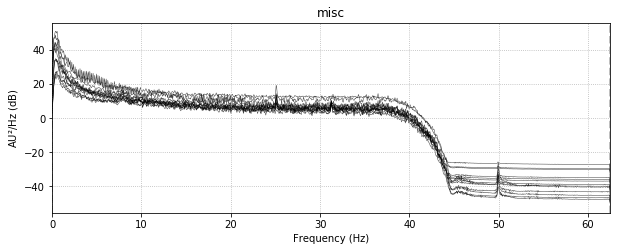

In [20]:
#------- todo: find out if this is a normal psd plot ------

# Params
eeg_clean_path = '../data/noam/2/EEG_clean.csv'
ch_names = ['C03', 'C04', 'P07', 'P089', 'O01', 'O02', 'F07', 'F08', 'F03', 'F04', 'T07', 'T08', 'P03']
s_rate = 125

# Create mne info & raw
eeg_clean = np.genfromtxt(eeg_clean_path, delimiter=',', skip_header=1)[:, 1:]
info = mne.create_info(ch_names, s_rate, verbose=False)
raw_eeg_clean = mne.io.RawArray(eeg_clean.T, info, verbose=False)

# Plot
fig = raw_eeg_clean.plot_psd(picks=ch_names, show=False)

### MI3 - Data Segmentation

In the `MI3_segment_data.py` script we split the data for each trial.
The start and end of each trial was according to the markers streaming we created
while recording the EEG. The script get the subject folder from the config file
(under `config['data']['subject_folder']`) and split for trial each
EEG record in each day.

The output of MI3 script is a pickle file named `EEG_trials.pickle` which
located in the corresponded day directory. The file is a list with ndarray
where each ndarray is the corresponded EEG data of the trial.

In [5]:
eeg_trials_path = '../data/noam/3/EEG_trials.pickle'
eeg_trials = pickle.load(open(eeg_trials_path, 'rb'))

print('Number of trials: {}\nTrials dimensions: {}'.format(len(eeg_trials), eeg_trials[0].shape))

Number of trials: 120
Trials dimensions: (616, 13)


And a PSD plot of various trial look like:


<ipython-input-22-6764d15b9a2d>:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  fig = eeg_trial.plot_psd(picks=ch_names)


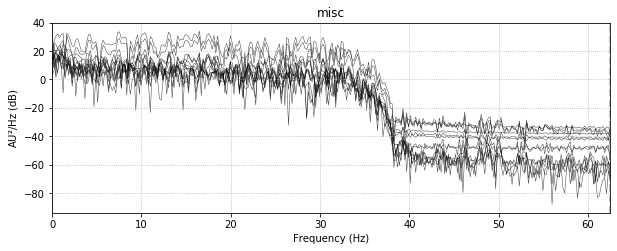

In [22]:
eeg_trial = mne.io.RawArray(eeg_trials[103].T, info, verbose=False)
fig = eeg_trial.plot_psd(picks=ch_names)

### MI4 - Feature Extraction

